# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

import plotly.graph_objects as go
from plotly.subplots import make_subplots


print("Setup complete")

Setup complete


# Importación de datos

In [2]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [3]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
wall_data.info()
wall_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11


#### Frecuencia de tiempo

In [4]:
# stores = wall_data
# stores = stores.iloc[:,[1,0,2]]

# Periodos de tiempo
# stores.Date = pd.PeriodIndex(stores.Date, freq='Y')
# stores.Date = pd.PeriodIndex(stores.Date, freq='M')
# stores.Date = pd.PeriodIndex(stores.Date, freq='d')
# stores.Date = pd.PeriodIndex(stores.Date, freq='q')
# stores.Date = pd.PeriodIndex(stores.Date, freq='w')

# stores = stores.groupby(['Date'])['Weekly_Sales'].aggregate([sum,min,'mean','count']).reset_index()
# stores = stores.groupby(['Date','Store'])['Weekly_Sales'].sum().reset_index()
# stores['Date'] = stores['Date'].astype(str)
# stores['Store'] = stores.Store.astype(str)
# stores['Date'] =pd.to_datetime(stores['Date'])
# stores.head()


stores = wall_data
stores = stores.iloc[:,[1,0,2]]
stores['year'] = pd.DatetimeIndex(stores['Date']).year
stores['month'] = pd.DatetimeIndex(stores['Date']).month
stores= stores.groupby(['year','month','Store'])[['Weekly_Sales']].mean().reset_index()
stores['year_str']=stores.year.apply(str)
stores['month_str']=stores.month.apply(str)
stores['Store'] = stores.Store.astype(str)
stores['year_month'] = stores[['year_str','month_str']].apply('-'.join,axis=1)
stores['Date']=pd.to_datetime(stores['year_month'],format="%Y-%m",yearfirst=True)
stores = stores.iloc[:,[7,2,3]]

stores.head()


,Date,Store,Weekly_Sales
0,2010-02-01,1,"1,576,836.02"
1,2010-02-01,2,"2,066,086.94"
2,2010-02-01,3,"427,799.56"
3,2010-02-01,4,"2,074,760.09"
4,2010-02-01,5,"300,682.00"


In [5]:
num_store = stores['Store'].unique()
num_store

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype=object)

In [6]:
# for i in num_store:
#     df = stores[stores['store']==i]
#     print(frame)
mes = {}
for store in num_store:
    df = stores[stores['Store']==store].copy()
    df.drop('Store',axis=1, inplace=True)
    mes[store] = df
    df.set_index('Date',inplace=True)

# Elegir una tienda    
# mes['20']

In [7]:
mes['20']

,Weekly_Sales
Date,
2010-02-01,"2,142,561.77"
2010-03-01,"1,994,194.99"
2010-04-01,"2,039,378.34"
2010-05-01,"2,032,533.96"
2010-06-01,"2,092,287.16"
2010-07-01,"2,027,849.45"
2010-08-01,"1,975,735.99"
2010-09-01,"1,968,640.91"
2010-10-01,"1,946,111.23"


#### Performance

In [8]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
# def cross_validation(model,a,b):
#     cv = cross_val_score(model,a,b,cv=10,scoring='r2')
#     print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [9]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

#### Diferencias

In [10]:
def dif(st):
    prev_values = st.Weekly_Sales.shift()
    dif = st.Weekly_Sales - prev_values
    dif.plot()

#### Estacionalidad

In [11]:
def estacionalidad(st):
    est = seasonal_decompose(st.iloc[1:],model='additive',period = 12)
    est.plot();

#### Conjunto de entrenamiento y test

In [12]:
def tra_tes(st):
    train = st.Weekly_Sales[:len(st.Weekly_Sales)-12]  # primero datos
    test = st.Weekly_Sales[len(st.Weekly_Sales)-12:]   # últimos datos 
    return train,test

## Mensual

In [13]:
m_20 =  mes['20'].rename_axis(index=None,columns=None)
m_14 =  mes['14'].rename_axis(index=None,columns=None) # No son datos estacionarios
m_5 =  mes['5'].rename_axis(index=None,columns=None)

<AxesSubplot:>

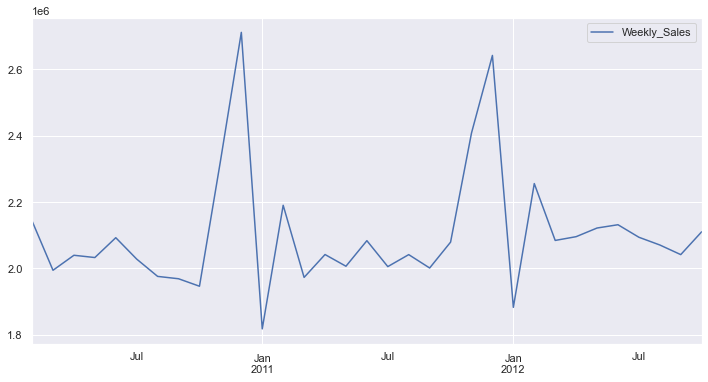

In [14]:
m_20.plot()

#### Prueba  Dickey Fuller Aumentada (ADF)

In [15]:
adf(m_20.Weekly_Sales,'Weekly_Sales')

Resultados ADF: ,Weekly_Sales
Test Statistic          -5.57
p-value                  0.00
No Lags Used             0.00
Observation number      32.00
Critical Values (1%)    -3.65
Critical Values (5%)    -2.96
Critical Values (10%)   -2.62
dtype: float64
Los datos son estacionarios


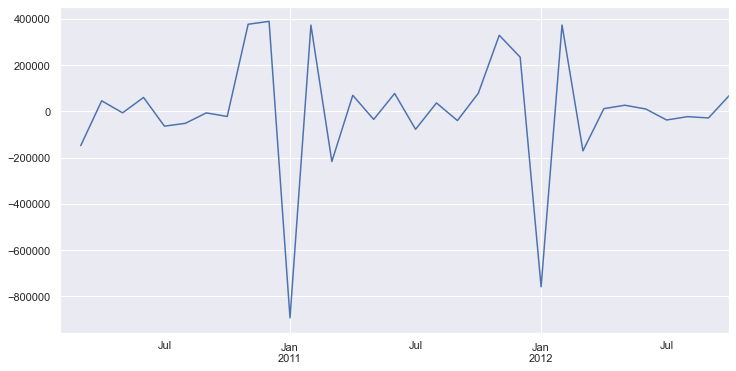

In [16]:
# prev_values = s_20.Weekly_Sales.shift()
# dif = s_20.Weekly_Sales - prev_values
# dif.plot()
dif(m_20)

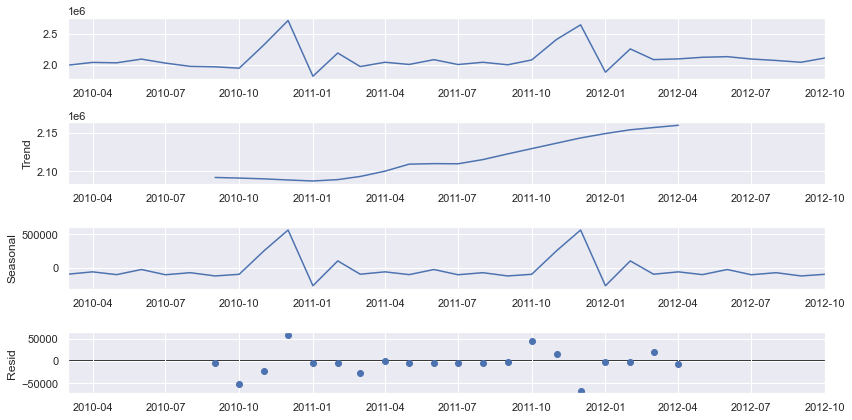

In [17]:
# differenced_store_20_dif = seasonal_decompose(s_20.iloc[1:],model='additive',period = 12)
# differenced_store_20_dif.plot();
estacionalidad(m_20)

### ARIMA

<AxesSubplot:>

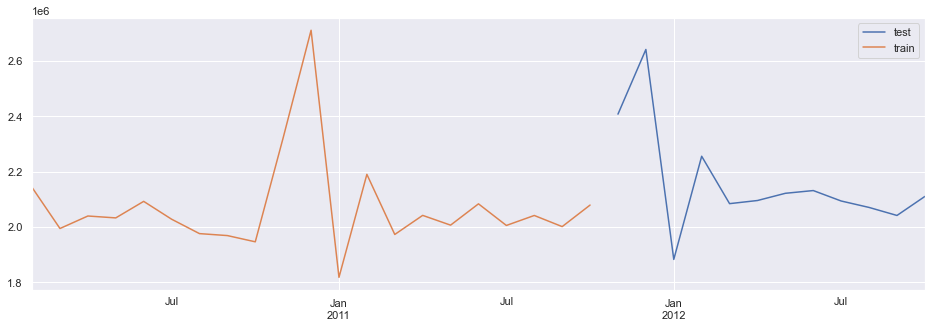

In [53]:
# train = s_20.Weekly_Sales[:len(s_20.Weekly_Sales)-12]  # primero datos
# test = s_20.Weekly_Sales[len(s_20.Weekly_Sales)-12:]   # últimos datos 

train, test = tra_tes(m_20)
test.plot(figsize=(16,5),legend=True, label='test')
train.plot(legend=True, label='train')

In [19]:
# Para determinar el train y el test, se sugiere que los datos asignados sean del 80% y 20% sucesivamente
# pero a mayor número de datos de entrenamiento, el AIC disminuye y el R2 aumenta
# caso contrario, el AIC aumenta y el R2 se hace negativo
# ¿De qué depende el periodo que se quiere calcular? Por ejemplo, yo determine 12 meses que se quieren predecir
print(len(train),len(test))

21 12


In [20]:
# Nunca se debe utilizar toda la información de un dataset, debe ser el dataset de train 
# para el entrenamiento de los modelo.
# El test nunca filtra inforamción al train.
# D:parametro parte estacional, d:parametro parte no estacional
arima_model = pm.auto_arima(train, start_p=0,d=0,start_q=0,max_p=5,max_d=5,max_q=5,
                            start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=12,
                            seasonal=True,error_Action='warn',trace=True,test='adf',
                            supress_warnings = True, stepwise=True, random_state=20,
                            n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=224.291, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=228.002, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=228.362, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=224.829, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=226.290, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=226.290, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=226.011, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=226.444, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=225.971, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.867 seconds


#### SARIMAX

In [20]:
# D:parametro parte estacional, d:parametro parte no estacional
arima_model = SARIMAX(train,order=(0,0,0),seasonal_order = (0,1,0,12))     #AIC 224.829; D=1;d=0 // Con estacionalidad
# arima_model = SARIMAX(train,order=(3,0,3),seasonal_order = (0,1,1,12))     #AIC 3,374.683; D=1;d=0 // Sin marcar periodo
arima_result = arima_model.fit() 
arima_result.summary()

C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             Weekly_Sales   No. Observations:                   21
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -111.415
Date:                  Thu, 08 Dec 2022   AIC                            224.829
Time:                          12:29:41   BIC                            225.026
Sample:                      02-01-2010   HQIC                           224.403
                           - 10-01-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.978e+09   4.81e+08      4.117      0.000    1.04e+09    2.92e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.61   Prob(JB):                         0.48
Heteroskedasticity (H):               8.48   Skew:                             0.99
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
arima_result.model_orders
# r2. si no hay una cte (ar,phi_0) en el modelo. este es negativo.
# el autoarima no tiene una cte 

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 0,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [46]:
arima_pred = arima_result.predict(start= len(train),end=len(m_20)-1,type='levels').rename('ARIMA Predictions')
arima_pred

2011-11-01   2,322,193.72
2011-12-01   2,710,758.33
2012-01-01   1,817,672.07
2012-02-01   2,189,938.99
2012-03-01   1,972,684.31
2012-04-01   2,041,621.16
2012-05-01   2,006,359.05
2012-06-01   2,083,331.58
2012-07-01   2,005,234.94
2012-08-01   2,041,298.79
2012-09-01   2,001,049.19
2012-10-01   2,078,938.47
Freq: MS, Name: ARIMA Predictions, dtype: float64

In [34]:
# len(m_20) #33
# len(m_20)-1 #32
# len(train) #21
# len(test) #12

<AxesSubplot:>

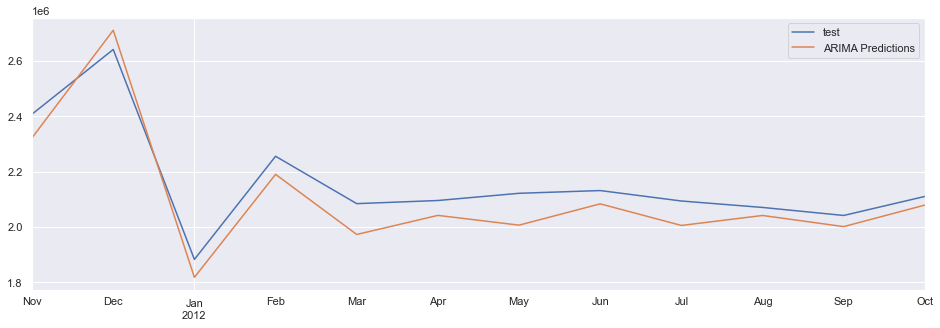

In [47]:
# train.plot(figsize=(16,5),legend=True)
# m_20.plot(figsize=(16,5),legend=True)
# train.plot(legend=True, label='train')
test.plot(figsize=(16,5),legend=True, label='test')
arima_pred.plot(legend=True, label='ARIMA Predictions')

Accuracy test(R2):  85.08172077109136
Mean Absolute Error:  66852.11704166663
Mean Square Error:  5224463219.885597
Root Mean Square Error:  72280.44839294784
Mean Absolute Percentage Error:  0.030986461666270827


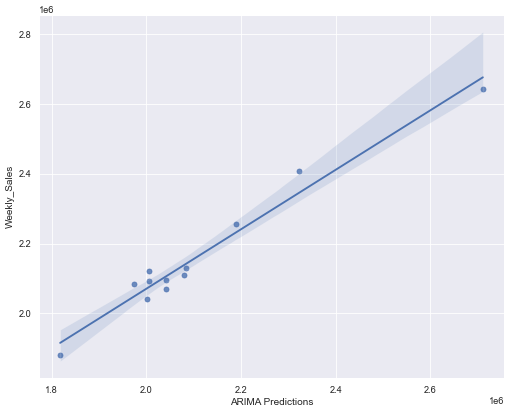

In [25]:
print('Accuracy test(R2): ', metrics.r2_score(test,arima_pred)*100)
performance(test,arima_pred)